# Import Libraries

In [6]:
## Import standard librarys
import torch
import torchdiffeq
import pickle
import time
import torch.nn as nn
import scipy.optimize as opt
import numpy as np

from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt


## Import local classes and functions
from MassFricParams import MassFricParams
from TimeSequenceGen import TimeSequenceGen
from AdjointMethod import AdjDerivs
from GradientDescent import GradDescent, objGradFunc

torch.set_default_dtype(torch.float)

In [13]:
a = torch.tensor(1.e30)
torch.asinh(a)

tensor(69.7707)

In [14]:
torch.log(2. * a)

tensor(69.7707)

# Calculate steady state friction coefficient

In [24]:
beta_targ = torch.tensor([0.011, 0.016, 0.1, 0.58])
beta = torch.tensor([ 0.0111, -0.0027,  0.1000,  0.2810])
V = torch.tensor([1., 10., 100.])

# Calculate stead state
def calFSS(beta, V):
    res = beta[3] + (beta[0] - beta[1]) * torch.log(V / 1.e-6)
    return res

In [2]:
a = torch.tensor([1, 2, 3, 4,])
b = torch.tensor([[1, 2, 4, 8], [2, 4, 6, 5]])
a * b

tensor([[ 1,  4, 12, 32],
        [ 2,  8, 18, 20]])

In [27]:
len(V.size())

1

In [ ]:
# Allocate memory
res = torch.zeros(len(tts), 2, self.kwgs['NofTpts'])
for idx, (tt, VV) in enumerate(zip(tts, VVs)):
    T = torch.linspace(tt[0], tt[-1], self.kwgs['NofTpts'])
    InterpFunc = interp1d(tt, VV)
    V = torch.tensor(InterpFunc(T), dtype = torch.float)
    res[idx, 1, :] = V
    res[idx, 0, :] = T
    
# Update self.tt, self.VV
self.tts = tts
self.VVs = VVs

In [21]:
calFSS(beta_targ, V)

tensor([0.5109, 0.4994, 0.4879])

In [22]:
calFSS(beta, V)

tensor([0.4717, 0.5034, 0.5352])

# Gradient descent on fixed $\alpha = [k, m, g]$ and $V$ 

In [5]:
# Set up the parameters
alpha0 = torch.tensor([50., 1., 9.8])
VT = torch.tensor([[1., 1.], [0., 5.]])

# Alpha range
alp_low = torch.tensor([50., 0.5, 1., 9.])
alp_hi = torch.tensor([100., 2., 10., 10.])
y0 = torch.tensor([0., 1.0, 1.0])

# Start beta
beta0 = torch.tensor([0.008, 0.012, 2.e0, 0.5])

# Target beta
beta_targ = torch.tensor([0.011, 0.016, 1.e0, 0.58])

# Beta ranges
beta_low = torch.tensor([0.001, 0.006, 0.5e-3, 0.3])
beta_high = torch.tensor([0.021, 0.026, 5, 0.8])
scaling = torch.tensor([1., 1., 1., 1.])

# Other arguments for optAlpha function
max_iters = 100
maxFuncCalls = 200
regularizedFlag = False
noLocalSearch = True

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-6
this_atol = 1.e-8

# Store the keywords for optAlpha
kwgs = {
    'y0' : y0, 
    'alpha0' : alpha0, 
    'VT' : VT,
    'alp_low' : alp_low, 
    'alp_high' : alp_hi, 
    'max_iters' : max_iters, 
    'beta_this' : beta0, 
    'beta_targ' : beta_targ, 
    'beta_low' : beta_low, 
    'beta_high' : beta_high, 
    'regularizedFlag' : regularizedFlag, 
    'maxFuncCalls' : maxFuncCalls, 
    'noLocalSearch' : noLocalSearch, 
    'T' : T, 
    'NofTPts' : NofTPts, 
    'this_rtol': this_rtol, 
    'this_atol' : this_atol
}

# Function to get target v
def generate_target_v(alpha, VT, beta, y0, this_rtol, this_atol, regularizedFlag):
    # y0[1] = alpha[2]
    targ_SpringSlider = MassFricParams(alpha, VT, beta, y0)
    targ_SpringSlider.print_info()
    targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, 
                               rtol=this_rtol, atol=this_atol, regularizedFlag=regularizedFlag)
    v = targ_seq.default_y[1, :], 
    t = targ_seq.t
    return v[0], t

########################################  Total Iteration 0 ########################################
--------------------  Mass and spring parameters  --------------------
k:         tensor(50.)
m:         tensor(1.)
g:         tensor(9.8000)


--------------------  Rate-and-state parameters  --------------------
fr:        tensor(0.5800)
a:         tensor(0.0110)
b:         tensor(0.0160)
DRS:       tensor(1.)
y0:        tensor([0., 1., 1.])


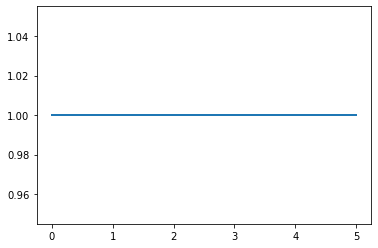

/home/shengduo/InverseProblems/AdjtMethod/MassFricParams.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s, dtype=torch.float)


Time cost in computing gradients:  0.45262575149536133
shit
Time cost in computing gradients:  0.44380927085876465
Initial descent succeeds:  tensor(True)
Observation:  tensor(0.0038)
Gradient (scaled):  tensor([-1.9977e+00,  3.2467e+00,  1.2518e-03, -2.2420e-01])
Relative error of observation:  tensor(0.0019)
Time cost in computing gradients:  0.36985158920288086
The 1th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-2.7512e-01,  2.5257e-01,  8.6851e-05, -1.7562e-02])
Relative error of observation:  tensor(0.0003)
Time cost in computing gradients:  0.3769958019256592
The 2th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-1.1474e-01, -3.5268e-02, -8.1763e-06,  2.3028e-03])
Relative error of observation:  tensor(0.0003)
Time cost in computing gradients:  0.3844032287597656
The 3th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-9.9088e-02, -5.2304e-02, -1.3675e-05,  3.4806e-03])
Relative error of observation:  tensor(0.0003)
Time cost in computin

KeyboardInterrupt: 

In [6]:
## Number of total alpha-beta iterations
N_AllIters = 1
this_alpha = alpha0
this_beta = beta0

## Run alpha-beta iterations
for i in range(N_AllIters):
    # Print out info
    print("#" * 40, " Total Iteration {0} ".format(i) + "#" * 40)
    
    ## First optimize alpha
    kwgs['alpha0'] = this_alpha
    kwgs['beta_this'] = this_beta
    
    # Timing alpha
    # Update this Alpha
    # this_alpha = optAlpha(O_GAN, kwgs)
    
    
    ## Run grad descent on beta
    # Generate target v
    v, t = generate_target_v(this_alpha, kwgs['VT'], kwgs['beta_targ'], kwgs['y0'], kwgs['this_rtol'], kwgs['this_atol'], kwgs['regularizedFlag'])
    
    # Run gradient descent
    myGradBB = GradDescent(this_alpha, kwgs['alp_low'], kwgs['alp_high'], kwgs['VT'], 
                           this_beta, kwgs['beta_low'], kwgs['beta_high'], 
                           kwgs['y0'], v, t, 
                           objGrad_func = objGradFunc, scaling = scaling, 
                           max_steps = 10, stepping = 'BB', obs_rtol = 1e-5, lsrh_steps = 10, 
                           regularizedFlag = kwgs['regularizedFlag'], 
                           T = kwgs['T'], NofTPts = kwgs['NofTPts'], this_rtol = kwgs['this_rtol'], this_atol = kwgs['this_atol'])
    
    myGradBB.run()
    
    # Update parameters
    this_beta = myGradBB.beta_optimal
    print("Optimal beta: ", this_beta)